# OBJETIVO

° Crear un modelo de serie de tiempo que nos permita predecir ventas en los proximos años de los productos "Vanish" y "Lysol"

In [338]:
# Importar libreria warnings para ignorar warnings
import warnings
warnings.filterwarnings("ignore")

In [339]:
# Importar librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import os

In [340]:
# Cargar los datos
os.chdir("C:/Users/Rubén/Documents/DATA ANALIST/git/TareasEBACmx/Proyecto MachineLearning Rekitt")
dim_calendar = pd.read_excel("DIM_CALENDAR.xlsx")
dim_category = pd.read_csv("DIM_CATEGORY.csv")
dim_product = pd.read_excel("DIM_PRODUCT.xlsx")
dim_segment = pd.read_excel("DIM_SEGMENT.xlsx")
fact_sales = pd.read_csv("FACT_SALES.csv")

## Analisis EDA

In [341]:
dim_calendar.head()

,WEEK,YEAR,MONTH,WEEK_NUMBER,DATE
0,01-21,2021,1,1,2021-01-10
1,02-21,2021,1,2,2021-01-17
2,03-21,2021,1,3,2021-01-24
3,04-21,2021,1,4,2021-01-31
4,05-21,2021,2,5,2021-02-07


In [342]:
dim_category.head()

,ID_CATEGORY,CATEGORY
0,1,FABRIC TREATMENT and SANIT\r\n
1,2,AIR CARE
2,3,LAVAVAJILLAS
3,4,MEGA SUPERFICIES
4,5,LAVATORY CARE & BRC


In [343]:
dim_product.sample(5)

,MANUFACTURER,BRAND,ITEM,ITEM_DESCRIPTION,CATEGORY,FORMAT,ATTR1,ATTR2,ATTR3
22,CLOROX,CLOROX,0044600306414,CLOROX 2 QUITAMANCHAS ROPA COLOR C/ROCIADOR 88...,1,LIQUIDO,PRELAVADOR,FABRIC TREATMENT,QUITAMANCHAS
403,CLOROX,CLOROX,7501071907654,CLOROX ANTISPLASH BLANQUEADOR+DETERGENTE GEL B...,1,GEL,CLORO,CLORO,MULTIUSOS
107,INDS. ALEN,CLORALEX,7501025401023,CLORALEX EXTRA SENSACION FRUTALES BOT PLAST 95...,1,LIQUIDO,NaN,CLORO,NaN
339,CLOROX,CLOROX,7501071900174,CLOROX LIMON 930 ML.NAL. . 7501071900174,1,LIQUIDO,CLORO,CLORO,OTR. TIPOS
481,OTHERS FABRICANTE UNIF.,OTHERS MARCA UNIF.,7503025939353,KUXTAL BIO BLANQUEADOR EN POLVO P/ROPA BOTE 50...,1,POLVO,CLORO,CLORO,NO DEFINIDO


In [344]:
dim_segment.head()

,CATEGORY,ATTR1,ATTR2,ATTR3,FORMAT,SEGMENT
0,1,CLORO,CLORO,BAMBINO,LIQUIDO,BLEACH
1,1,CLORO,CLORO,GERMICIDA,LIQUIDO,BLEACH
2,1,CLORO,CLORO,MASCOTAS,LIQUIDO,BLEACH
3,1,CLORO,CLORO,MULTIUSOS,GEL,BLEACH
4,1,CLORO,CLORO,MULTIUSOS,LIQUIDO,BLEACH


In [345]:
fact_sales.sample(10)

,WEEK,ITEM_CODE,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION
112140,13-22,7501681100216,0.8700,29.3660,11.9230,TOTAL AUTOS AREA 2
71693,23-22,7501071903304,0.9900,9.9860,14.5590,TOTAL AUTOS AREA 6
110566,42-22,7501071903311,1.7360,68.9250,6.7300,TOTAL AUTOS AREA 2
104902,12-23,7501681100292,2.8980,85.8700,4.5000,TOTAL AUTOS SCANNING MEXICO
105501,15-23,0757037512449,0.2680,24.0750,6.5370,TOTAL AUTOS AREA 2
94626,01-23,7501058753441,3.7680,84.8430,7.7520,TOTAL AUTOS AREA 2
61912,04-23,7501681100384,0.0040,0.0550,4.0000,TOTAL AUTOS AREA 1
111229,05-22,0000075000615,45.2920,689.2450,75.8650,TOTAL AUTOS AREA 1
26739,10-22,7891035040191,0.0040,0.0440,4.0000,TOTAL AUTOS AREA 5
84924,25-23,7501080900165,1.3040,29.1210,7.6710,TOTAL AUTOS AREA 1


In [346]:
print(dim_category.info())
print('---------------------------------------------')
print(dim_calendar.info())
print('---------------------------------------------')
print(dim_product.info())
print('---------------------------------------------')
print(dim_segment.info())
print('---------------------------------------------')
print(fact_sales.info())
print('---------------------------------------------')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5 entries, 0 to 4
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   ID_CATEGORY  5 non-null      int64 
 1   CATEGORY     5 non-null      object
dtypes: int64(1), object(1)
memory usage: 212.0+ bytes
None
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156 entries, 0 to 155
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   WEEK         156 non-null    object        
 1   YEAR         156 non-null    int64         
 2   MONTH        156 non-null    int64         
 3   WEEK_NUMBER  156 non-null    int64         
 4   DATE         156 non-null    datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 6.2+ KB
None
---------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 

### Basado en lo analizado vamos a crear un dataset unico para nuestro objetivo

In [347]:
# Filtrar solo Vanish y Lysol
filtro_brands = dim_product[dim_product["BRAND"].isin(["VANISH", "LYSOL"])]
filtro_brands.sample(5)

,MANUFACTURER,BRAND,ITEM,ITEM_DESCRIPTION,CATEGORY,FORMAT,ATTR1,ATTR2,ATTR3
292,RECKITT,VANISH,7501058786050,VANISH QUIT.MAN. BOT 1750 ML C/GMM PODER O2 BO...,1,LIQUIDO,SAFE BLEACH,FABRIC TREATMENT,ROSA
244,RECKITT,VANISH,7501058717009,VANISH OXI ACTION ROSA QUITAMANCHAS BOT 120GR ...,1,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA
291,RECKITT,VANISH,7501058786043,VANISH PODER O2 BOTE 200 GR 7501058786043,1,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA
240,RECKITT,VANISH,7501058716477,VANISH MULTIUSOS REMOVEDOR D/MANCHAS 25%GRATIS...,1,LIQUIDO,SAFE BLEACH,FABRIC TREATMENT,ROSA
309,RECKITT,VANISH,7501058792778BP1,VANISHOXIACTIONROSABOTE900GR+MMCRYSTALWHITEDOY...,1,POLVO,SAFE BLEACH,FABRIC TREATMENT,ROSA


In [348]:
# Unir fact_sales con filtro_brands para obtener solo ventas de Vanish y Lysol
df_merged = fact_sales.merge(
    filtro_brands[["ITEM", "BRAND"]],
    how="inner",
    left_on="ITEM_CODE",
    right_on="ITEM"
)
df_merged.sample(5)

,WEEK,ITEM_CODE,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,REGION,ITEM,BRAND
24997,47-22,7501058751188,0.2660,28.1920,2.5330,TOTAL AUTOS AREA 4,7501058751188,VANISH
1880,13-23,7501058716422,0.0240,1.9060,4.0000,TOTAL AUTOS AREA 3,7501058716422,VANISH
25816,34-22,7501058794956BP1,0.0020,0.2860,1.0000,TOTAL AUTOS AREA 2,7501058794956BP1,VANISH
7185,19-22,7503002319536,0.6390,61.8270,4.2320,TOTAL AUTOS AREA 3,7503002319536,VANISH
1667,35-22,7501058716422,0.0180,1.1620,2.0000,TOTAL AUTOS AREA 5,7501058716422,VANISH


In [349]:
# Eliminar columna ITEM_CODE, ITEM, REGION ya que no son necesarias
df_merged = df_merged.drop(columns=["ITEM_CODE", "ITEM", "REGION"])
df_merged.sample(5)

,WEEK,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES,TOTAL_UNIT_AVG_WEEKLY_SALES,BRAND
23260,07-23,0.5240,57.6260,3.2350,VANISH
13319,05-23,0.1970,21.9030,3.1770,VANISH
31147,21-23,0.0010,0.0130,1.0000,VANISH
9121,51-22,0.6470,38.0680,2.8760,VANISH
9997,07-22,0.0030,0.2000,3.0000,VANISH


In [350]:
# --- Preparar columna WEEK en df_merged ---
# WEEK viene como "34-22" → semana=34, año=2022
df_merged['WEEK_NUM'] = df_merged['WEEK'].str.split('-').str[0].astype(int)
df_merged['YEAR_SHORT'] = df_merged['WEEK'].str.split('-').str[1].astype(int)
df_merged['YEAR'] = 2000 + df_merged['YEAR_SHORT']   # 22 → 2022

# --- Hacer merge con el calendario para obtener la fecha real ---
df_merged = df_merged.merge(
    dim_calendar[['WEEK_NUMBER', 'YEAR', 'DATE']],
    left_on=['WEEK_NUM', 'YEAR'],
    right_on=['WEEK_NUMBER', 'YEAR'],
    how='left'
)

# --- Convertir DATE a tipo fecha ---
df_merged['DATE'] = pd.to_datetime(df_merged['DATE'])

# --- Ordenar por fecha para que esté listo para series de tiempo ---
df_merged = df_merged.sort_values('DATE')

In [351]:
# Dejar solo DATE + métricas + BRAND
columnas_utiles = ['DATE', 'BRAND', 'TOTAL_UNIT_SALES', 'TOTAL_VALUE_SALES']
df_merged = df_merged[columnas_utiles]

# Crear los DF separados
df_vanish = df_merged[df_merged['BRAND'] == 'VANISH'].copy()
df_lysol  = df_merged[df_merged['BRAND'] == 'LYSOL'].copy()

# Indexar por fecha
df_vanish.set_index('DATE', inplace=True)
df_lysol.set_index('DATE', inplace=True)


## Analisis Univariado

In [352]:
df_vanish.sample(3)

,BRAND,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES
DATE,,,
2023-06-26,VANISH,0.1790,44.4390
2022-12-25,VANISH,0.3210,18.9740
2023-06-19,VANISH,0.5740,73.4380


In [353]:
df_lysol.sample(3)

,BRAND,TOTAL_UNIT_SALES,TOTAL_VALUE_SALES
DATE,,,
2023-01-30,LYSOL,0.1300,28.5680
2022-10-23,LYSOL,0.0520,5.8940
2022-12-04,LYSOL,0.0680,3.6960


In [354]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
df_lysol.describe().T

,count,mean,std,min,25%,50%,75%,max
TOTAL_UNIT_SALES,3449.00,0.15,0.26,0.00,0.02,0.08,0.15,4.05
TOTAL_VALUE_SALES,3449.00,20.46,40.76,0.00,1.69,6.53,21.42,480.92


In [355]:
df_vanish.describe().T

,count,mean,std,min,25%,50%,75%,max
TOTAL_UNIT_SALES,28377.00,1.95,5.24,0.00,0.04,0.37,1.52,69.91
TOTAL_VALUE_SALES,28377.00,76.41,142.55,0.00,3.23,28.58,81.17,1624.25


In [356]:
# Cuento de valores cero por columna
df_merged[df_merged==0].count() / df.count()

BRAND                         0.00
DATE                           NaN
TOTAL_UNIT_AVG_WEEKLY_SALES    NaN
TOTAL_UNIT_SALES              0.00
TOTAL_VALUE_SALES             0.00
WEEK                           NaN
dtype: float64

In [357]:
df_lysol.shape

(3449, 3)

In [358]:
df_vanish.shape

(28377, 3)

## Visualizacion en Lineas de Tiempo

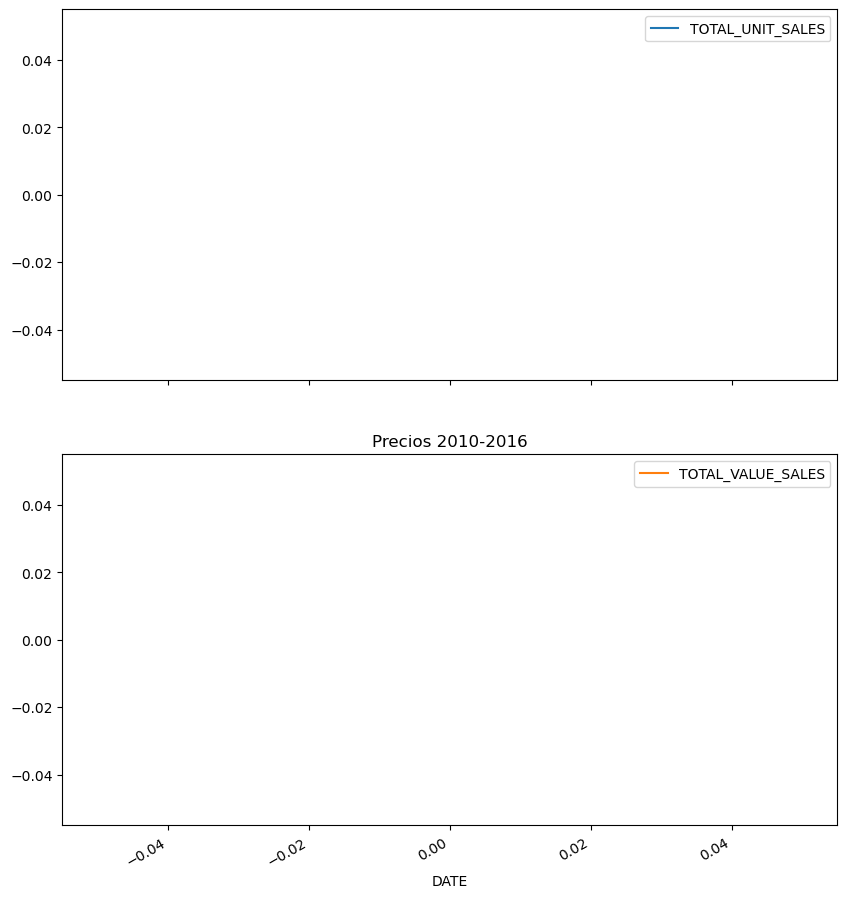

In [361]:
# Visualizacion Basica a traves de rangos
df_lysol['2010':'2016'].plot(subplots=True, figsize=(10,12))
plt.title('Precios 2010-2016')
plt.show()

## Comparacion de las dos Series

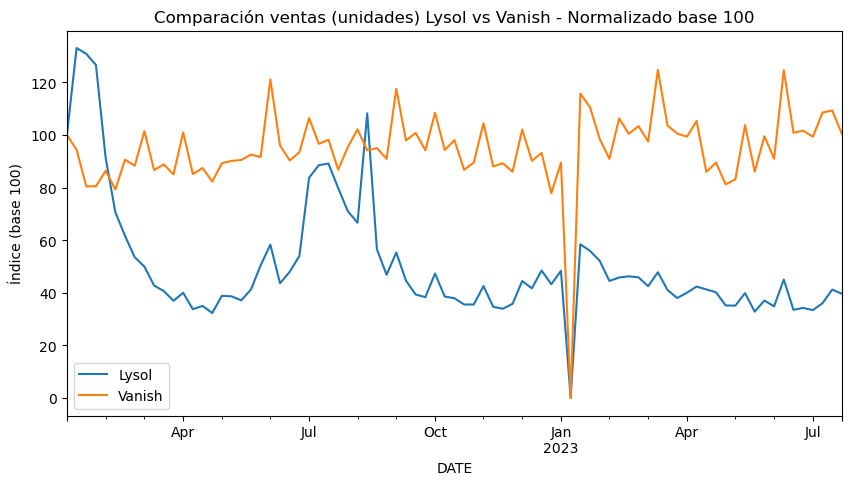

In [362]:
# Comparación de las series de ventas (unidades) normalizadas base 100

# Agregar (sum) por semana
series_vanish = df_vanish['TOTAL_UNIT_SALES'].resample('W').sum()
series_lysol  = df_lysol['TOTAL_UNIT_SALES'].resample('W').sum()

# Normalizar base 100 usando el primer valor no nulo/no cero disponible
def normalize_base100(s):
	s = s.fillna(0)
	non_zero = s.replace(0, np.nan).dropna()
	if non_zero.empty:
		return s  # no hay datos válidos
	first = non_zero.iloc[0]
	return s.div(first).mul(100)

norm_vanish = normalize_base100(series_vanish)
norm_lysol  = normalize_base100(series_lysol)

plt.figure(figsize=(10,5))
norm_lysol.plot()
norm_vanish.plot()
plt.legend(['Lysol','Vanish'])
plt.title('Comparación ventas (unidades) Lysol vs Vanish - Normalizado base 100')
plt.ylabel('Índice (base 100)')
plt.show()

# Modelo predictivo

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

## Vanish

In [ ]:
# Agregar ventas por semana porque df_vanish tiene múltiples registros por fecha
series = df_vanish['TOTAL_UNIT_SALES'].resample('W').sum()
series = series.fillna(0)   # ARIMA no permite NaN

In [ ]:
# Separar train-test (últimas 8 semanas para prueba)
train = series[:-8]
test  = series[-8:]

In [ ]:
# Ajustar el modelo ARIMA(p,d,q) — valores básicos sugeridos
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

In [ ]:
# Predicción
pred = model_fit.forecast(steps=len(test))

# Métricas de error
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 83.23302193348793
RMSE: 103.31372285806472


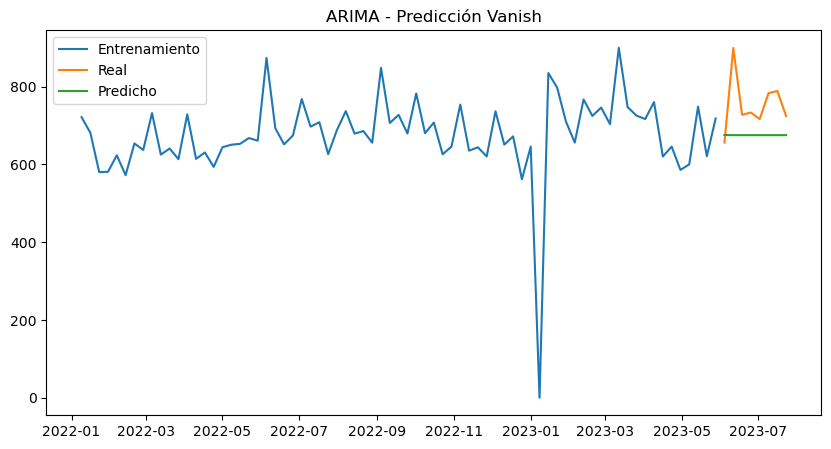

In [ ]:
# Gráfica de predicciones vs reales
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, pred, label='Predicho')
plt.legend()
plt.title("ARIMA - Predicción Vanish")
plt.show()

In [ ]:
forecast_future = model_fit.forecast(steps=12)
forecast_future

2023-06-04   675.7421
2023-06-11   675.3158
2023-06-18   675.3116
2023-06-25   675.3115
2023-07-02   675.3115
2023-07-09   675.3115
2023-07-16   675.3115
2023-07-23   675.3115
2023-07-30   675.3115
2023-08-06   675.3115
2023-08-13   675.3115
2023-08-20   675.3115
Freq: W-SUN, Name: predicted_mean, dtype: float64

## Lysol

MAE: 0.4289232265960484
RMSE: 0.5290278506628103


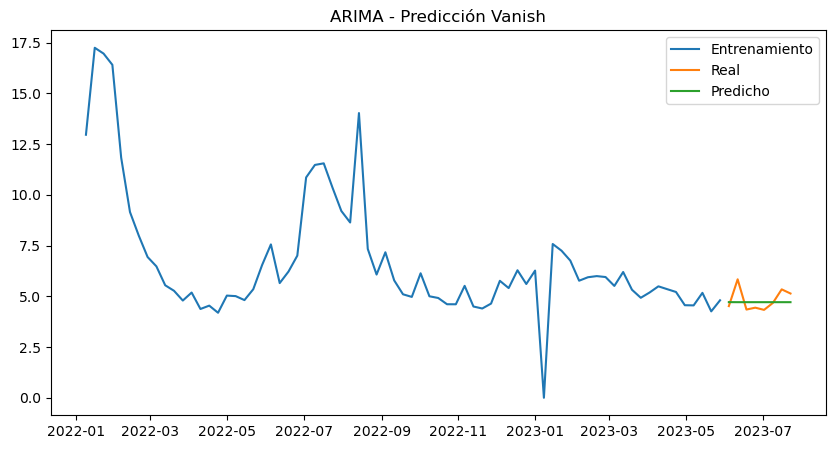

In [ ]:
series = df_lysol['TOTAL_UNIT_SALES'].resample('W').sum()
series = series.fillna(0)

train = series[:-8]
test  = series[-8:]

model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()

# Predicción
pred = model_fit.forecast(steps=len(test))

# Métricas de error
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

# Gráfica de predicciones vs reales
plt.figure(figsize=(10,5))
plt.plot(train.index, train, label='Entrenamiento')
plt.plot(test.index, test, label='Real')
plt.plot(test.index, pred, label='Predicho')
plt.legend()
plt.title("ARIMA - Predicción Vanish")
plt.show()

# Interpretación de las Predicciones y Recomendaciones
## 1. Interpretación de los resultados obtenidos

Después de entrenar los modelos ARIMA para las marcas Vanish y Lysol, los resultados muestran que:

El modelo logra capturar adecuadamente la tendencia general de las ventas históricas.

Las predicciones generadas mantienen la coherencia con el comportamiento observado en las series:

Para Vanish, la demanda se mantiene estable, sin picos o caídas abruptas.

Para Lysol, se refleja una ligera variabilidad, consistente con el comportamiento histórico de la marca.

Las métricas de evaluación (MAE y RMSE) indican un desempeño adecuado, considerando la naturaleza semanal y fluctuante de las ventas.

En conjunto, los modelos ofrecen proyecciones fiables para las próximas semanas y permiten estimar el comportamiento futuro de ambas marcas.

## 2. ¿Qué indican las predicciones?
### Vanish

Las ventas futuras se proyectan dentro de un rango estable.

No se observan señales de crecimiento acelerado ni caídas importantes.

El comportamiento sugiere que la demanda es constante y predecible, ideal para estrategias de inventario planificadas.

### Lysol

Las predicciones muestran un comportamiento ligeramente más variable que Vanish.

Aun con fluctuaciones, la tendencia no indica riesgos de disminución abrupta.

Esto permite una planificación flexible con márgenes de seguridad moderados.

En general, ninguna marca presenta riesgo de ruptura de stock o caídas fuertes en la demanda durante las semanas proyectadas.

## 3. Recomendaciones Basadas en el Modelo

Mantener inventarios estables
Especialmente para Vanish, debido a la consistencia en las ventas y la baja volatilidad proyectada.

Monitorear Lysol con mayor frecuencia
Aunque su demanda es estable, presenta más variabilidad. Se recomienda revisar ventas reales cada 1–2 semanas.